## Hands-on EESREP 6 : Flexible nuclear and CCGT plants supplying a balanced electric grid

This serie of file "Hands-on EESREP" is dedicated to the study of flexibility features in the EESREP simulation model. The primary objective is to incorporate advanced components whose flexibility is in some way restricted by physical phenomena or safety regulations.

The tutorial use_2_three_components_model.ipynb serves as the foundation for this code, which will introduce flexibility restrictions to the nuclear cluster in Hands-on EESREP 2, while the CCGT model will remain optimistic. Hence, the model uses seven main components:

-   load: fatal sink that consumes a predetermined amount of energy ;

-   cluster_Nuke: group of N1 nuclear power plants that produce energy between its minimal and maximal power when turned-on ;
-   cluster_CCGT: group of N2 Combined Cycle Gas Turbine (CCGT) that produce energy between its minimal and maximal power when turned-on ;

-   fuel_Nuke: provides the energy requested by the cluster_Nuke ;
-   fuel_CCGT: provides the energy requested by the cluster_CCGT ;

-   demand-side management: virtual production plant - that provides the system with unsupplied_energy - ensures the equilibrium between energy bid and ask. The energy is charged at a significantly higher rate compared to the rate of physical assets ;
-   spilled_energy: physical consumption plant that will consume energy on demand to ensure an equilibrium between energy bid and ask when flexibility restrictions induce a spread. The charge for consumption is intended to prevent the solver from overproducing.

A "bus" has been added to enable Kirchhoff's junction rule between the inputs and the outputs.

The model's structure can be exemplified as follows:

                                             | -->  load
              fuel_Nuke --> cluster_Nuke --> |
              fuel_CCGT --> cluster_CCGT --> |
                  demand-side management --> |
                                             | --> spilled_energy


Added in v4:
-   crédit K monitoring rule compatible with IRSN/ASN/EDF statements.

Added in v5:
- Other load profiles

Added in v6:
- Two flexible units

Added in v7:
- Three flexible units

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from eesrep import Eesrep
from eesrep.components.generic_component import GenericComponent
from eesrep.components.converter import Cluster
from eesrep.components.sink_source import FatalSink, Source, Sink
from eesrep.eesrep_enum import TimeSerieType
from eesrep.eesrep_io import ComponentIO
from eesrep.solver_interface.generic_interface import GenericInterface

### Simulation parameters

In [2]:
global_time_step = 1                                                                        # Time step size (hours)
global_time_shift = 50                                                                      # Shift between the beginning of two sucessing horizon (time steps)
global_future_size = 100                                                                    # Duration of each horizon (time steps)
global_horizon_count = 95                                                                   # Number of horizons to solve (horizon)

max_load = 2000.            # MWh
min_load = 0.               # MWh
load_period = 24            # h
load_amplitude = 0.2        # 20 % of max_load

global_step_count = (global_horizon_count - 1) * global_time_shift + global_future_size     # Calculates the total number of time steps
#print("Nombre de pas de simulation :", global_step_count)                                  # Prints the previous value if needed

# True activates the spilled energy virtual sink and demand-side management virtual source
global_bool_virtual_balancing = True
global_load_type = "linear"
# 1/2/12 activates one/one/two perturbation(s) on load to be set in user-defined inputs section
global_load_perturbation = 0


### Individual nuclear power plant behaviour constraints
# True activates ramping constraints
global_NPP_bool_ramps = False
# True activates ELPO credit constraints
global_NPP_bool_creditFPPI = True
# True activates minimum steady duration after transitions
global_NPP_bool_duration = False
# Set the date of the end of the planned stop for refueling
global_date_fin_AR = 0
# True activates the full power equivalent days monitoring
global_NPP_bool_fpd = True


### Energy mix configuration
# True instanciates nuclear individual powerplants
global_bool_Nuke_indiv = True
# True instanciates nuclear clusterized powerplants
global_bool_Nuke_cluster = False
# True instanciates CCGT clusterized powerplants
global_bool_CCGT_cluster = False
# True instanciates OCGT clusterized powerplants
global_bool_OCGT_cluster = False

# Coal and fuel to be implemented in v3

global_bool_nuke = global_bool_Nuke_cluster + global_bool_Nuke_indiv                        # Calculates if nuclear fuel has to be instanciated
global_bool_gaz = global_bool_CCGT_cluster + global_bool_OCGT_cluster                       # Calculates if gaz fuel has to be instanciated

## Model definition

### Custom components definition

In [3]:
class FlexiblePP_static(GenericComponent):
    """EESREP flexible power plant static model : The output evolution satisfies ramps and ELPO constraints."""

    def __init__(self, 
                 name:str,
                 fpd_max:float,
                 rs_duration:float,
                 efficiency:float,
                 average_lf:float,
                 p_max:float,
                 p_min_rel:float,
                 fuel_weight:float,
                 opex:float,
                 turn_on_price:float,
                 ramp_up:float,
                 ramp_down:float,
                 bool_ramps:bool,
                 creditELPOmax:float,
                 bool_creditFPPI:bool,
                 bool_duration:bool,
                 date_fin_AR:float,
                 some_ts:pd.DataFrame = pd.DataFrame()):
        
        self.name = name
        self.fpd_max = fpd_max
        self.rs_duration = rs_duration
        self.efficiency = efficiency
        self.average_lf = average_lf
        self.p_max = p_max
        self.p_min_off = 0
        self.p_min_on = p_min_rel * p_max
        self.fuel_weight = fuel_weight
        self.opex = opex
        self.turn_on_price = turn_on_price
        self.ramp_up = ramp_up
        self.ramp_down = ramp_down
        self.bool_ramps = bool_ramps
        self.creditELPOmax = creditELPOmax
        self.bool_creditFPPI = bool_creditFPPI
        self.bool_duration = bool_duration
        self.date_fin_AR = date_fin_AR

        #   Necessary object, instanciate empty if not used
        self.time_series = {
            # "some_time_serie":{
            #     "type":TimeSerieType.INTENSIVE,
            #     "value":some_ts
            # } 
        }

        self.CS = ComponentIO(self.name, "CS", TimeSerieType.INTENSIVE, True)
        self.HS = ComponentIO(self.name, "HS", TimeSerieType.INTENSIVE, True)
        self.LPO = ComponentIO(self.name, "LPO", TimeSerieType.INTENSIVE, True)
        self.PO = ComponentIO(self.name, "PO", TimeSerieType.INTENSIVE, True)
        self.fpd = ComponentIO(self.name, "fpd", TimeSerieType.INTENSIVE, True)
        self.burn_up = ComponentIO(self.name, "burn_up", TimeSerieType.INTENSIVE, True)
        self.creditELPO = ComponentIO(self.name, "creditELPO", TimeSerieType.INTENSIVE, True)
        self.creditK_out = ComponentIO(self.name, "creditK_out", TimeSerieType.INTENSIVE, True)
        self.countLPO = ComponentIO(self.name, "countLPO", TimeSerieType.INTENSIVE, True)
        self.is_step_ELPO = ComponentIO(self.name, "is_step_ELPO", TimeSerieType.INTENSIVE, True)
        self.electricity = ComponentIO(self.name, "electricity", TimeSerieType.INTENSIVE, True)
        self.fuel = ComponentIO(self.name, "fuel", TimeSerieType.INTENSIVE, False)

    def io_from_parameters(self) -> dict:
        """Lists the component Input/Output.
        """
        return {
                    "CS" : self.CS,
                    "HS" : self.HS,
                    "LPO" : self.LPO,
                    "PO" : self.PO,
                    "fpd" : self.fpd,
                    "burn_up" : self.burn_up,
                    "creditELPO" : self.creditELPO,
                    "creditK_out" : self.creditK_out,
                    "countLPO" : self.countLPO,
                    "is_step_ELPO" : self.is_step_ELPO,
                    "electricity" : self.electricity,
                    "fuel" : self.fuel
                }
    
    def build_model(self,
        component_name:str,
        time_steps:list,
        time_series:pd.DataFrame,
        history:pd.DataFrame,
        model_interface:GenericInterface):
        """Builds the model at the current horizon.

        Parameters
        ----------
        component_name : str
            Component name to index the MILP variables
        time_steps : list
            List of the time steps length 
        time_series : pd.DataFrame
            Dataframe containing the time series values at the current horizon time steps.
        history : pd.DataFrame
            Dataframe with the variables of previous iterations if "continuity" is at true.
        model_interface : GenericInterface
            Solver interface used to provide the variables

        """

        variables = {}

        if True:
            variables["CS"] = model_interface.get_new_discrete_variable_list(component_name+"_CS_", len(time_steps), 0, 1)
            variables["HS"] = model_interface.get_new_discrete_variable_list(component_name+"_HS_", len(time_steps), 0, 1)
            variables["LPO"] = model_interface.get_new_discrete_variable_list(component_name+"_LPO_", len(time_steps), 0, 1)
            variables["PO"] = model_interface.get_new_discrete_variable_list(component_name+"_PO_", len(time_steps), 0, 1)

            variables["fpd"] = model_interface.get_new_continuous_variable_list(component_name+"_fpd_", len(time_steps), 0., self.fpd_max)
            variables["burn_up"] = model_interface.get_new_continuous_variable_list(component_name+"_burnup_", len(time_steps), 0., None)
            variables["creditELPO"] = model_interface.get_new_continuous_variable_list(component_name+"_creditELPO_", len(time_steps), 0., self.creditELPOmax)
            variables["creditK_out"] = model_interface.get_new_continuous_variable_list(component_name+"_creditK_out_", len(time_steps), 0., self.creditELPOmax)
            variables["countLPO"] = model_interface.get_new_continuous_variable_list(component_name+"_countLPO_", len(time_steps), 0., None)
            variables["is_step_ELPO"] = model_interface.get_new_discrete_variable_list(component_name+"_is_step_ELPO_", len(time_steps), 0, 1)
            variables["fuel"] = model_interface.get_new_continuous_variable_list(component_name+"_fuel_", len(time_steps), 0, None)
            variables["electricity"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_", len(time_steps), self.p_min_off, self.p_max)

            ratio_p_min_p_max_LPO = [0 for i in range(len(time_steps))]
            p_max_LPO_p_max = [0 for i in range(len(time_steps))]
            ratio_p_min_p_max_PO = [0 for i in range(len(time_steps))]
        # end if True to collapse variable declaration

        if True:
            if len(history) == 0:
                previous_horizon_fpd = 0
            else:
                previous_horizon_fpd = history.loc[len(history)-1,"fpd"]
            
            burn_up_horizon = previous_horizon_fpd/self.fpd_max
            # print(f"Burn-up horizon: {burn_up_horizon}")
        # end if True to collapse burn_up_horizon calculation

        ###################################################################################################
        ###################################################################################################
        ###################################################################################################
        ######################### Instantiation of constraints at each time_step ##########################
        ###################################################################################################
        ###################################################################################################
        ###################################################################################################
        for i in range(len(time_steps)):
            if True:
                # Intermediate assignement of the current step
                current_step_elec = variables["electricity"][i]
                #current_step_CS = variables["CS"][i]
                current_step_fpd = variables["fpd"][i]
                current_step_creditELPO = variables["creditELPO"][i]
                current_step_countLPO = variables["countLPO"][i]
                current_step_is_step_ELPO = variables["is_step_ELPO"][i]

                # Intermediate assignement of the previous step
                if i == 0:
                    # First step of the current horizon : the previous step may not exist and might be fetched in the history
                    if len(history) == 0:
                        # First time step of the first horizon
                        previous_step_elec = 0
                        previous_step_fpd = 0
                        previous_step_creditELPO = 200
                    else:
                        # First time step of a generic horizon
                        previous_step_elec = history.loc[len(history)-1,"electricity"]
                        previous_step_fpd = history.loc[len(history)-1,"fpd"]

                        if self.bool_creditFPPI:
                            # Recalculates the credit K after the preceding horizon maneuvers
                            for i2 in range(global_time_shift):
                                past_step_index = len(history)-(global_time_shift-i2)
                                past_step_is_ELPO = history.loc[past_step_index,"is_step_ELPO"]
                                
                                if past_step_index - 1 < 0:
                                    past_past_step_creditELPO = 200
                                elif i2 == 0:
                                    past_past_step_creditELPO = history.loc[len(history) - 1,"creditK_out"]
                                else:
                                    past_past_step_creditELPO = new_creditK
                                # end if

                                if past_step_is_ELPO:
                                    # Debit credit K according to burn-up and power level
                                    if True:
                                        past_step_power = history.loc[past_step_index,"electricity"]
                                        past_step_fpd = history.loc[past_step_index,"fpd"]
                                        past_step_burnup = (past_step_fpd * self.p_max / self.efficiency) / self.fuel_weight

                                        if past_step_burnup <= 2000:
                                            if past_step_power < 0.85 * self.p_max:
                                                A_i = 4.9
                                            else:
                                                A_i = 2.8
                                            # end if
                                        elif past_step_burnup <= 6000:
                                            if past_step_power < 0.85 * self.p_max:
                                                A_i = 6.1
                                            else:
                                                A_i = 2.3
                                            # end if
                                        else:
                                            if past_step_power < 0.5 * self.p_max:
                                                A_i = 4.1
                                            else:
                                                A_i = 6.3
                                            # end if
                                        # end if

                                        B_j = 0
                                    # end if True to collapse crédit K coefficients for ELPO

                                else:
                                    if True:
                                        past_step_PO = history.loc[past_step_index,"PO"]
                                        # if past_step_index - 1 >= 0:
                                        #     past_past_step_creditK = history.loc[past_step_index - 1,"creditK"]
                                        # else:
                                        #     past_past_step_creditK = 200
                                        # # end if

                                        if past_step_PO:
                                            if past_past_step_creditELPO <= 100:
                                                B_j = 8 - 0.07 * past_past_step_creditELPO
                                            elif past_past_step_creditELPO <= 199:
                                                B_j = 1
                                            else:
                                                B_j = 0
                                            # end if
                                        else:
                                            B_j = 0
                                        # end if
                                            
                                        A_i = 0
                                    # end if True to collapse crédit K coefficients for non-ELPO
                                # end if
                                        
                                old_creditK = history.loc[past_step_index,"creditELPO"]
                                new_creditK = past_past_step_creditELPO - A_i / 24 + B_j / 24
                                
                                # THIS LINE IS NOT VALID: HISTORY IS READ ONLY AND CANNOT BE OVERWRITTEN
                                history.loc[past_step_index,"creditELPO"] = new_creditK
                            # end for

                            # previous_step_creditELPO = history.loc[len(history)-1,"creditELPO"]
                            previous_step_creditELPO = new_creditK
                        # end if self.bool_creditFPPI to collapse creditELPO calculation after horizon
                else:
                    # Generic time step of a generic horizon
                    previous_step_elec = variables["electricity"][i-1]
                    previous_step_fpd = variables["fpd"][i-1]
                    previous_step_creditELPO = variables["creditELPO"][i-1]
                # end if

                if True:
                    # Intermediate assignement of the boolean reflecting CS value at step i-16
                    if i <= 16:
                        # First sixteen steps of the current horizon : the "16-steps-before" step may not exist and might be fetched in the history
                        if len(history) == 0:
                            # Not fetchable because not yet defined, let's assume that the first value of the first horizon fits the purpose
                            CSd_16 = variables["CS"][0]
                        else:
                            # Fetchable in the history
                            CSd_16 = history.loc[len(history)-1 + (i-16),"CS"]
                        # end if
                    else:
                        # Fetchable in current horizon
                        CSd_16 = variables["CS"][i-16]
                    # end if
                #end if True to collapse the constraint on cold shutdown duration
            # end if True to collapse intermediate assignment of current_step and previous_step variables, and crédit K coefficients if enabled

            if True:
                # Static constraint of imperfect transformation of inputs into outputs
                model_interface.add_equality(left_term = variables["electricity"][i], 
                                            right_term = variables["fuel"][i]*self.efficiency)

                # Mutual exclusivity of states
                model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                    variables["CS"][i],
                                                                    variables["HS"][i],
                                                                    variables["LPO"][i],
                                                                    variables["PO"][i]
                                                                ]),
                                            right_term = 1)
                
                ### Calculation of the evolution of the irradiation campaign in equivalent days at full power ("fpd")
                if global_NPP_bool_fpd:
                    model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                    current_step_fpd,
                                                                    -previous_step_fpd
                                                                ]), 
                                                right_term = current_step_elec/self.p_max/24)
                # end if global_NPP_bool_fpd
            # end if True to collapse fundamental rules on state, input/output and jepp counting
            
            ### Calculation of the approximate instantaneous burn_up to calculate the local p_min according to the real burn_up at the begining of the horizon and the average load factor
            if True:
                burn_up_approx = burn_up_horizon + (i/24*self.average_lf)/self.fpd_max
                # print(f"Burn-up au pas {i} : {burn_up_approx}")

                # Adjusts the local jig for P_min in LPO
                if burn_up_approx <= 0.1:
                    # No flexibility allowed right after the refueling shutdown
                    ratio_p_min_p_max_LPO[i] = 1
                    ratio_p_min_p_max_PO[i] = 1
                    p_max_LPO_p_max[i] = 1
                elif burn_up_approx <= 0.65:
                    ratio_p_min_p_max_LPO[i] = 0.2
                    ratio_p_min_p_max_PO[i] = 0.92 - 1e-6
                    p_max_LPO_p_max[i] = ratio_p_min_p_max_PO[i]
                elif burn_up_approx <= 0.9:
                    ratio_p_min_p_max_LPO[i] = 0.2 + (burn_up_approx-0.65) * (0.86-0.2)/(0.9-0.65)
                    ratio_p_min_p_max_PO[i] = 0.92 - 1e-6
                    p_max_LPO_p_max[i] = ratio_p_min_p_max_PO[i]
                else:
                    ratio_p_min_p_max_LPO[i] = 0.86
                    ratio_p_min_p_max_PO[i] = 0.92 - 1e-6
                    p_max_LPO_p_max[i] = ratio_p_min_p_max_PO[i]
                # end if

                model_interface.add_equality(left_term = variables["burn_up"][i], 
                                             right_term = burn_up_approx)
            # end if True to collapse burn_up calculation
            
            if True:
                # Static constraints of limited output range while running
                model_interface.add_lower_than(left_term = variables["electricity"][i], 
                                            right_term = model_interface.sum_variables([
                                                                    0 * variables["CS"][i],
                                                                    0.02 * self.p_max * variables["HS"][i],
                                                                    p_max_LPO_p_max[i] * self.p_max * variables["LPO"][i],
                                                                    self.p_max * variables["PO"][i]
                                                                ])
                                                            )

                # Minimum power constraint with p_min varying at each time step
                model_interface.add_greater_than(left_term = variables["electricity"][i], 
                                                right_term = model_interface.sum_variables([
                                                                    0 * variables["CS"][i],
                                                                    0.02 * self.p_max * variables["HS"][i],
                                                                    self.p_max * ratio_p_min_p_max_LPO[i] * variables["LPO"][i],
                                                                    ratio_p_min_p_max_PO[i] * self.p_max * variables["PO"][i]
                                                                ])
                                                            )
            # end if True to collapse output level jig according to state and burnup
        
            if self.bool_ramps:
                # Case first horizon:
                    # Ramping up: CS_i-16 cannot be fetched in history. Let's assume that CS_0 is a suitable value until i > 16
                    # Ramping down: relaxed, no constraint mentionned in EDF's STE
                # Case generic horizon:
                    # Ramping up: CS_i-16 can be fetched in history until i > 16
                    # Ramping down: relaxed, no constraint mentionned in EDF's STE

                # A working ramping down constraint code is provided below if needed but would require minor ajustements (relaxed if CS is not null at the current timestep)

                # Ramping up constraint, relaxed if CS is not null at the current-16 timestep
                model_interface.add_lower_than(left_term = model_interface.sum_variables([
                                                                    current_step_elec,
                                                                    -previous_step_elec
                                                                ]),
                                                right_term = model_interface.sum_variables([
                                                                    self.ramp_up * self.p_max * CSd_16,
                                                                    1e9 * (1 - CSd_16)
                                                                ]))
                # No more ramping down constraint
                pass
                ## Ramping down constraint, relaxed if CS is not null at the current timestep
                #model_interface.add_lower_than(left_term = model_interface.sum_variables([
                #                                                    previous_step_elec,
                #                                                    -current_step_elec
                #                                                ]),
                #                            right_term = model_interface.sum_variables([
                #                                                    self.p_max * self.ramp_down,
                #                                                    (current_step_CS) * 1e9
                #                                                ]))
            # end if self.bool_ramps
                
            if self.bool_creditFPPI:
                # Intermediate evaluation of LPO duration on the 24 time steps before the current step
                sommeLPO = []
                for j in range(24):
                    if i-j >= 0:
                        sommeLPO.append(variables["LPO"][i-j])
                    elif len(history) > 0 and len(history)+i-j >= 0:
                        sommeLPO.append(history["LPO"].iloc[len(history)+i-j])
                    # end if
                # end for
                
                model_interface.add_equality(left_term = current_step_countLPO,
                                                right_term = model_interface.sum_variables(sommeLPO))

                # Forces MILP solver to switch is_step_ELPO to 1 if countLPO is beyond "8 hours out of 24" threshold
                model_interface.add_lower_than(left_term = model_interface.sum_variables([
                                                current_step_countLPO,
                                                - 15e3 * current_step_is_step_ELPO
                                                ]),
                                                right_term = 8)

                # Only debits creditELPO conservatively with higher A_i coefficient value. Crediting is operated between horizons
                model_interface.add_equality(left_term = model_interface.sum_variables([
                                                current_step_creditELPO,
                                                -previous_step_creditELPO
                                                ]), 
                                                right_term = - 6.3 / 24 * current_step_is_step_ELPO
                                            )
                
                # Virtual variable to output the last correct value known for credit ELPO
                if len(history) > 0:
                    if i < global_future_size - global_time_shift:
                        model_interface.add_equality(left_term = variables["creditK_out"][i], right_term = history.loc[len(history) - global_time_shift + i,"creditELPO"])
                    # end if
                # end if
            # end if self.bool_creditFPPI 
        # end for
        
        

        objective = model_interface.sum_variables([val for val in variables["is_step_ELPO"]])
        
        return variables, objective

### User-defined inputs

#### Load

In [4]:

if global_load_type == "linear":
    perturb1_start = 250        # h
    perturb1_end = 500          # h
    perturb1_level = 15.        # MWh

    perturb2_start = 750        # h
    perturb2_end = 980          # h
    perturb2_level = 0.        # MWh


    if global_load_perturbation == 12 and perturb1_end <= perturb2_start:
        ### Generating a linear load ranging from min_load to max_load with two low load perturbations between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end))*((i<perturb2_start) + (i>perturb2_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
    elif global_load_perturbation == 1:
        ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 for i in range(global_step_count + 1)]})
    elif global_load_perturbation == 2:
        ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb2_start) + (i>perturb2_end)) + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
    else:
        ### Generating a linear load ranging from min_load to max_load
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count) for i in range(global_step_count + 1)]})
    # end if

elif global_load_type == "sin":
    average_load = (min_load + max_load) / 2
    load_pulse = 2 * np.pi / load_period

    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(average_load * (1 - load_amplitude * np.sin(load_pulse * i))) for i in range(global_step_count + 1)]})
    
elif global_load_type == "duck":
    average_load = (min_load + max_load) / 2
    load_pulse = 2 * np.pi / load_period

    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(average_load * (1 - load_amplitude * (np.sin(load_pulse * i) + 2 * (np.sin(2*load_pulse * i)) * ((i%24 <=18)*(i%24 >=12))))) for i in range(global_step_count + 1)]})
#end if

#### Nuclear power plant with ramping constraints

In [5]:
### NPP caracteristics (most reference values found in ITESE A-B use case)
NPP_cycle_duration_fpd = 300            # Duration of the irradiation campaign in full power equivalent days
NPP_RS_duration = 30*24                 # Standard duration of the refueling stop
NPP_efficiency = 0.33                   # Fuel to electricity ratio, no cogeneration considered
NPP_average_lf = 0.81                   # Average load factor during a campaign
NPP_P_max = 1086.                       # Average nominal power (electric) in the french fleet
NPP_P_min_rel = 0.4                     # Minimum relative output before shutdown
NPP_fuel_weight = 0.002 * 264 * 185     # Weight of the fuel in core (tons) : 2kg * 264 fuel rods * 185 assemblies (average)
NPP_duration_on = 12                    # Minimum time enabled after turning on
NPP_duration_off = 16                   # Minimum time disabled after turning off
NPP_ramp_up = 0.03                      # Maximum ramping up rate after Cold Shutdown and refueling/repositioning stops
NPP_ramp_down = 0.005                   # Maximum ramping down rate
NPP_creditELPOmax = 200.                # Maximum credit ELPO consumption

### Clusterized NPP caracteristics
N1 = 10                                 # Number of NPP in the cluster

### Economic value
NPP_OPEX = 14.5                         # Cost of energy (€/MWh)
NPP_turn_on_price = 28. * NPP_P_max     # Cost of switching on (€/MW) multiplied by maximum power
NPP_FOPEX = 0.01                        # Default to disable cluster when useless (€/h)


#### CCGT cluster

In [6]:
### CCGT caracteristics (reference values found in ITESE A-B use case)
CCGT_efficiency = 0.57                      # Fuel to electricity ratio, no cogeneration considered
CCGT_P_max = 10.                            # Arbitrary
CCGT_P_min_rel = 0.4                        # Minimum relative output before shutdown
CCGT_duration_on = 2                        # Minimum time enabled after turning on
CCGT_duration_off = 2                       # Minimum time disabled after turning off

### cluster_CCGT caracteristics
N2 = 10                                     # Number of CCGTs in the cluster

### Economic value
CCGT_OPEX = 210.                            # Cost of energy (€/MWh)
CCGT_turn_on_price = 278. * CCGT_P_max      # Cost of switching on (€/MW) multiplied by maximum power
CCGT_FOPEX = 0.01                           # Default to disable cluster when useless (€/h)


#### Demand-side management : unsupplied energy

In [7]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
DSM_efficiency = 1.                     # Fuel to electricity ratio, no cogeneration considered
DSM_P_max = None                        # Arbitrary
DSM_P_min_rel = 0.                      # Minimum relative output before shutdown
DSM_duration_on = 6.                    # Minimum time enabled after turning on
DSM_duration_off = 1.                   # Minimum time disabled after turning off
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

### Economic virtual value
DSM_OPEX = 500.e9                       # Cost of energy (€/MWh)
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

#### Spilled energy

In [8]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
SE_efficiency = 1.                      # Fuel to electricity ratio, no cogeneration considered
SE_P_max = None                         # Arbitrary
SE_P_min_rel = 0.                       # Minimum relative output before shutdown
SE_duration_on = 1.                     # Minimum time enabled after turning on
SE_duration_off = 1.                    # Minimum time disabled after turning off
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

### Economic virtual value
SE_OPEX = 500                           # Cost of energy (€/MWh)
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

#### Fuels

In [9]:
fuel_Nuke_price = NPP_OPEX * NPP_efficiency     # Default: back-calculation of the cost of nuclear fuel with NPP OPEX
fuel_Nuke_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_Nuke_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None


fuel_CCGT_price = CCGT_OPEX * CCGT_efficiency   # Default: back-calculation of the cost of CCGT fuel with CCGT OPEX
fuel_CCGT_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_CCGT_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None

fuel_DSM_price = DSM_OPEX * DSM_efficiency      # Default: back-calculation of the cost of DSM fuel with DSM OPEX
fuel_DSM_lb = 0.                                # Minimum consumption rate
fuel_DSM_ub = None                              # Maximum consumption rate

###   Model and components instantiation

The following blocks generates the EESREP object and each component.

In [10]:
model = Eesrep(interface="docplex")
model.define_time_range(time_step = global_time_step, 
                        time_shift = global_time_shift, 
                        future_size = global_future_size, 
                        horizon_count = global_horizon_count)

### Load
load = FatalSink(name="load", 
                    sink_flow = fs_df)
model.add_component(load)


#### Fuel source components

In [11]:
if global_bool_nuke:
    fuel_Nuke = Source(name="fuel_Nuke",
                    p_max = fuel_Nuke_ub,
                    p_min = fuel_Nuke_lb,
                    price = fuel_Nuke_price)
    model.add_component(fuel_Nuke)
# end if

if global_bool_gaz:
    fuel_CCGT = Source(name="fuel_CCGT",
                    p_max = fuel_CCGT_ub,
                    p_min = fuel_CCGT_lb,
                    price = fuel_CCGT_price)
    model.add_component(fuel_CCGT)
# end if


#### Individual flexible power plant components

In [12]:
if global_bool_Nuke_indiv:
    flexible_static_Nuke = FlexiblePP_static(name="flexible_static_Nuke",
                                            fpd_max = NPP_cycle_duration_fpd,
                                            rs_duration = NPP_RS_duration,
                                            efficiency = NPP_efficiency,
                                            average_lf = NPP_average_lf,
                                            p_max = NPP_P_max,
                                            p_min_rel = NPP_P_min_rel,
                                            fuel_weight= NPP_fuel_weight,
                                            opex = NPP_OPEX,
                                            turn_on_price = NPP_turn_on_price,
                                            ramp_up = NPP_ramp_up,
                                            ramp_down = NPP_ramp_down,
                                            bool_ramps = global_NPP_bool_ramps,
                                            creditELPOmax = NPP_creditELPOmax,
                                            bool_creditFPPI = global_NPP_bool_creditFPPI,
                                            bool_duration = global_NPP_bool_duration,
                                            date_fin_AR = global_date_fin_AR)
    
    flexible_static_Nuke2 = FlexiblePP_static(name="flexible_static_Nuke2",
                                            fpd_max = NPP_cycle_duration_fpd,
                                            rs_duration = NPP_RS_duration,
                                            efficiency = NPP_efficiency,
                                            average_lf = NPP_average_lf,
                                            p_max = NPP_P_max,
                                            p_min_rel = NPP_P_min_rel,
                                            fuel_weight= NPP_fuel_weight,
                                            opex = NPP_OPEX / 2,
                                            turn_on_price = NPP_turn_on_price,
                                            ramp_up = NPP_ramp_up,
                                            ramp_down = NPP_ramp_down,
                                            bool_ramps = global_NPP_bool_ramps,
                                            creditELPOmax = NPP_creditELPOmax,
                                            bool_creditFPPI = global_NPP_bool_creditFPPI,
                                            bool_duration = global_NPP_bool_duration,
                                            date_fin_AR = global_date_fin_AR)
    flexible_static_Nuke3 = FlexiblePP_static(name="flexible_static_Nuke3",
                                            fpd_max = NPP_cycle_duration_fpd,
                                            rs_duration = NPP_RS_duration,
                                            efficiency = NPP_efficiency,
                                            average_lf = NPP_average_lf,
                                            p_max = NPP_P_max,
                                            p_min_rel = NPP_P_min_rel,
                                            fuel_weight= NPP_fuel_weight,
                                            opex = NPP_OPEX / 4,
                                            turn_on_price = NPP_turn_on_price,
                                            ramp_up = NPP_ramp_up,
                                            ramp_down = NPP_ramp_down,
                                            bool_ramps = global_NPP_bool_ramps,
                                            creditELPOmax = NPP_creditELPOmax,
                                            bool_creditFPPI = global_NPP_bool_creditFPPI,
                                            bool_duration = global_NPP_bool_duration,
                                            date_fin_AR = global_date_fin_AR)
    model.add_component(flexible_static_Nuke)
    model.add_component(flexible_static_Nuke2)
    model.add_component(flexible_static_Nuke3)
# end if

#### Clusterized power plants components

In [13]:
if global_bool_Nuke_cluster:
    cluster_Nuke = Cluster(name="cluster_Nuke",
                                    efficiency = NPP_efficiency,
                                    p_max = NPP_P_max,
                                    p_min = NPP_P_min_rel * NPP_P_max,
                                    n_machine_max = N1,
                                    duration_on = NPP_duration_on,
                                    duration_off = NPP_duration_off,
                                    turn_on_price = NPP_turn_on_price)
    model.add_component(cluster_Nuke)
# end if

if global_bool_CCGT_cluster:
    cluster_CCGT = Cluster(name="cluster_CCGT",
                                    efficiency = CCGT_efficiency,
                                    p_max = CCGT_P_max,
                                    p_min = CCGT_P_min_rel * CCGT_P_max,
                                    n_machine_max = N2,
                                    duration_on = CCGT_duration_on,
                                    duration_off = CCGT_duration_off,
                                    turn_on_price = CCGT_turn_on_price)
    model.add_component(cluster_CCGT)
# end if

#### Virtual balancing components : spilled energy and demand-side management

In [14]:
if global_bool_virtual_balancing:
    DSM = Source(name="Demand_side_Management",
                p_max = fuel_DSM_ub,
                p_min = fuel_DSM_lb,
                price = fuel_DSM_price)
    model.add_component(DSM)

    spilled = Sink(name="spilled_energy", 
                p_min = 0.,
                p_max = SE_P_max,
                price = SE_OPEX)
    model.add_component(spilled)
# end if

#### Virtual OPEX calculation sinks

In [15]:
### Virtual sinks for fixed OPEX of power plants and clusters
if global_bool_Nuke_indiv:
    price_flexible_static_Nuke_on = Sink(name="price_flexible_static_Nuke_on", 
                                     p_min=0.,
                                     p_max=None,
                                     price = NPP_FOPEX)
    model.add_component(price_flexible_static_Nuke_on)
# end if

if global_bool_Nuke_cluster:
    price_cluster_Nuke_on = Sink(name="price_cluster_Nuke_on", 
                            p_min=0.,
                            p_max=None,
                            price = NPP_FOPEX)
    model.add_component(price_cluster_Nuke_on)
# end if

if global_bool_CCGT_cluster:
    price_cluster_CCGT_on = Sink(name="price_cluster_CCGT_on", 
                            p_min=0.,
                            p_max=None,
                            price = CCGT_FOPEX)
    model.add_component(price_cluster_CCGT_on)
# end if

#### Bus plugs

In [16]:
model.create_bus(bus_type = "bus", 
                 options = {"name":"bus_1"
                })

model.plug_to_bus(io = load.power_in,
                  bus_name = "bus_1",
                  is_input = False,
                  factor = 1., offset = 0.)

if global_bool_virtual_balancing:                   
    model.plug_to_bus(io = DSM.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
    model.plug_to_bus(io = spilled.power_in,
                      bus_name = "bus_1",
                      is_input = False,
                      factor = 1., offset = 0.)
# end if

if global_bool_Nuke_indiv:
    model.plug_to_bus(io = flexible_static_Nuke.electricity,
                    bus_name = "bus_1",
                    is_input = True,
                    factor = 1., offset = 0.)
    model.plug_to_bus(io = flexible_static_Nuke2.electricity,
                    bus_name = "bus_1",
                    is_input = True,
                    factor = 1., offset = 0.)
    model.plug_to_bus(io = flexible_static_Nuke3.electricity,
                    bus_name = "bus_1",
                    is_input = True,
                    factor = 1., offset = 0.)
# end if

if global_bool_Nuke_cluster:
    model.plug_to_bus(io = cluster_Nuke.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
# end if    

if global_bool_CCGT_cluster:
    model.plug_to_bus(io = cluster_CCGT.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
# end if

#### Model links

In [17]:
### Links between clusterized power plants and fuel sources. Note that flexible individual power plants already charge for opex instrinsically
if global_bool_Nuke_indiv:
   model.add_link(io_1 = fuel_Nuke.power_out,
                  io_2 = flexible_static_Nuke.fuel,
                  factor=1., offset=0.)
   model.add_link(io_1 = fuel_Nuke.power_out,
                  io_2 = flexible_static_Nuke2.fuel,
                  factor=1., offset=0.)
   model.add_link(io_1 = fuel_Nuke.power_out,
                  io_2 = flexible_static_Nuke3.fuel,
                  factor=1., offset=0.)
# end if

if global_bool_Nuke_cluster:
    model.add_link(io_1 = fuel_Nuke.power_out,
                   io_2 = cluster_Nuke.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_CCGT_cluster:
    model.add_link(io_1 = fuel_CCGT.power_out,
                   io_2 = cluster_CCGT.power_in,
                   factor=1., offset=0.)
# end if
    

### Links between the number of power plants activated and virtual OPEX sinks
if global_bool_Nuke_indiv:
    model.add_link(io_1=flexible_static_Nuke.CS,
                   io_2=price_flexible_static_Nuke_on.power_in,
                   factor=-1., offset=1.)
    model.add_link(io_1=flexible_static_Nuke2.CS,
                   io_2=price_flexible_static_Nuke_on.power_in,
                   factor=-1., offset=1.)
    model.add_link(io_1=flexible_static_Nuke3.CS,
                   io_2=price_flexible_static_Nuke_on.power_in,
                   factor=-1., offset=1.)
# end if

if global_bool_Nuke_cluster:
    model.add_link(io_1=cluster_Nuke.n_machine,
                   io_2=price_cluster_Nuke_on.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_CCGT_cluster:
    model.add_link(io_1=cluster_CCGT.n_machine,
                   io_2=price_cluster_CCGT_on.power_in,
                   factor=1., offset=0.)
# end if

## Simulation

In [18]:
#try:
model.solve({"write_problem":True, "write_log":True})
#except UnsolvableProblemException:
#    print("The problem is not solvable!")

Running first time step
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 8
CPXPARAM_RandomSeed                              201804051
CPXPARAM_MIP_Strategy_StartAlgorithm             6
CPXPARAM_MIP_Tolerances_MIPGap                   0
Found incumbent of value 1.0520833e+15 after 0.00 sec. (0.49 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 1524 rows and 1824 columns.
MIP Presolve modified 276 coefficients.
Aggregator did 1176 substitutions.
Reduced MIP has 700 rows, 1000 columns, and 2100 nonzeros.
Reduced MIP has 700 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (11.93 ticks)
Probing time = 0.00 sec. (0.78 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 675 rows and 956 columns.
Reduced MIP has 25 rows, 44 columns, and 75 nonzeros.
Reduced MIP has 23 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.75 ticks)
P

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 8
CPXPARAM_RandomSeed                              201804051
CPXPARAM_MIP_Strategy_StartAlgorithm             6
CPXPARAM_MIP_Tolerances_MIPGap                   0
Found incumbent of value 2.0937500e+15 after 0.00 sec. (0.50 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 1674 rows and 1824 columns.
MIP Presolve modified 276 coefficients.
Aggregator did 1176 substitutions.
Reduced MIP has 700 rows, 1000 columns, and 2100 nonzeros.
Reduced MIP has 700 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.04 ticks)
Probing time = 0.00 sec. (0.78 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 675 rows and 956 columns.
Reduced MIP has 25 rows, 44 columns, and 75 nonzeros.
Reduced MIP has 23 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.75 ticks)
Probing time = 0.00 sec. 

In [19]:
results = model.get_results(as_dataframe=False)

In [20]:
if True:
    print(results.keys())

    if global_bool_Nuke_indiv:
        print(results["flexible_static_Nuke"].keys())
    # end if

    if global_bool_Nuke_cluster:
        print(results["cluster_Nuke"].keys())
    # end if

    if global_bool_CCGT_cluster:
        print(results["cluster_CCGT"].keys())
    # end if
# end if True to collapse the bloc

dict_keys(['load', 'fuel_Nuke', 'flexible_static_Nuke', 'flexible_static_Nuke2', 'flexible_static_Nuke3', 'Demand_side_Management', 'spilled_energy', 'price_flexible_static_Nuke_on', 'time'])
dict_keys(['CS', 'HS', 'LPO', 'PO', 'fpd', 'burn_up', 'creditELPO', 'creditK_out', 'countLPO', 'is_step_ELPO', 'fuel', 'electricity'])


## Displaying results

### P_min profile generation for plot

In [21]:
ratio_p_min = [0 for i in range(global_step_count)]
ratio_p_min2 = [0 for i in range(global_step_count)]
ratio_p_min3 = [0 for i in range(global_step_count)]

for i in range(global_step_count):
    burn_up = results["flexible_static_Nuke"]["burn_up"][i]
    burn_up2 = results["flexible_static_Nuke2"]["burn_up"][i]
    burn_up3 = results["flexible_static_Nuke2"]["burn_up"][i]

    if burn_up <= 0.1:
        ratio_p_min[i] = 100
    elif burn_up <= 0.65:
        ratio_p_min[i] = 0.2*100
    elif burn_up <= 0.9:
        ratio_p_min[i] = (0.2 + (burn_up-0.65) * (0.86-0.2)/(0.9-0.65))*100
    else:
        ratio_p_min[i] = 0.86*100
    # end if 1

    if burn_up2 <= 0.1:
        ratio_p_min2[i] = 100
    elif burn_up2 <= 0.65:
        ratio_p_min2[i] = 0.2*100
    elif burn_up2 <= 0.9:
        ratio_p_min2[i] = (0.2 + (burn_up2-0.65) * (0.86-0.2)/(0.9-0.65))*100
    else:
        ratio_p_min2[i] = 0.86*100
    # end if 2

    if burn_up3 <= 0.1:
        ratio_p_min3[i] = 100
    elif burn_up3 <= 0.65:
        ratio_p_min3[i] = 0.2*100
    elif burn_up3 <= 0.9:
        ratio_p_min3[i] = (0.2 + (burn_up3-0.65) * (0.86-0.2)/(0.9-0.65))*100
    else:
        ratio_p_min3[i] = 0.86*100
    # end if 3
# end for

### Plotting the results

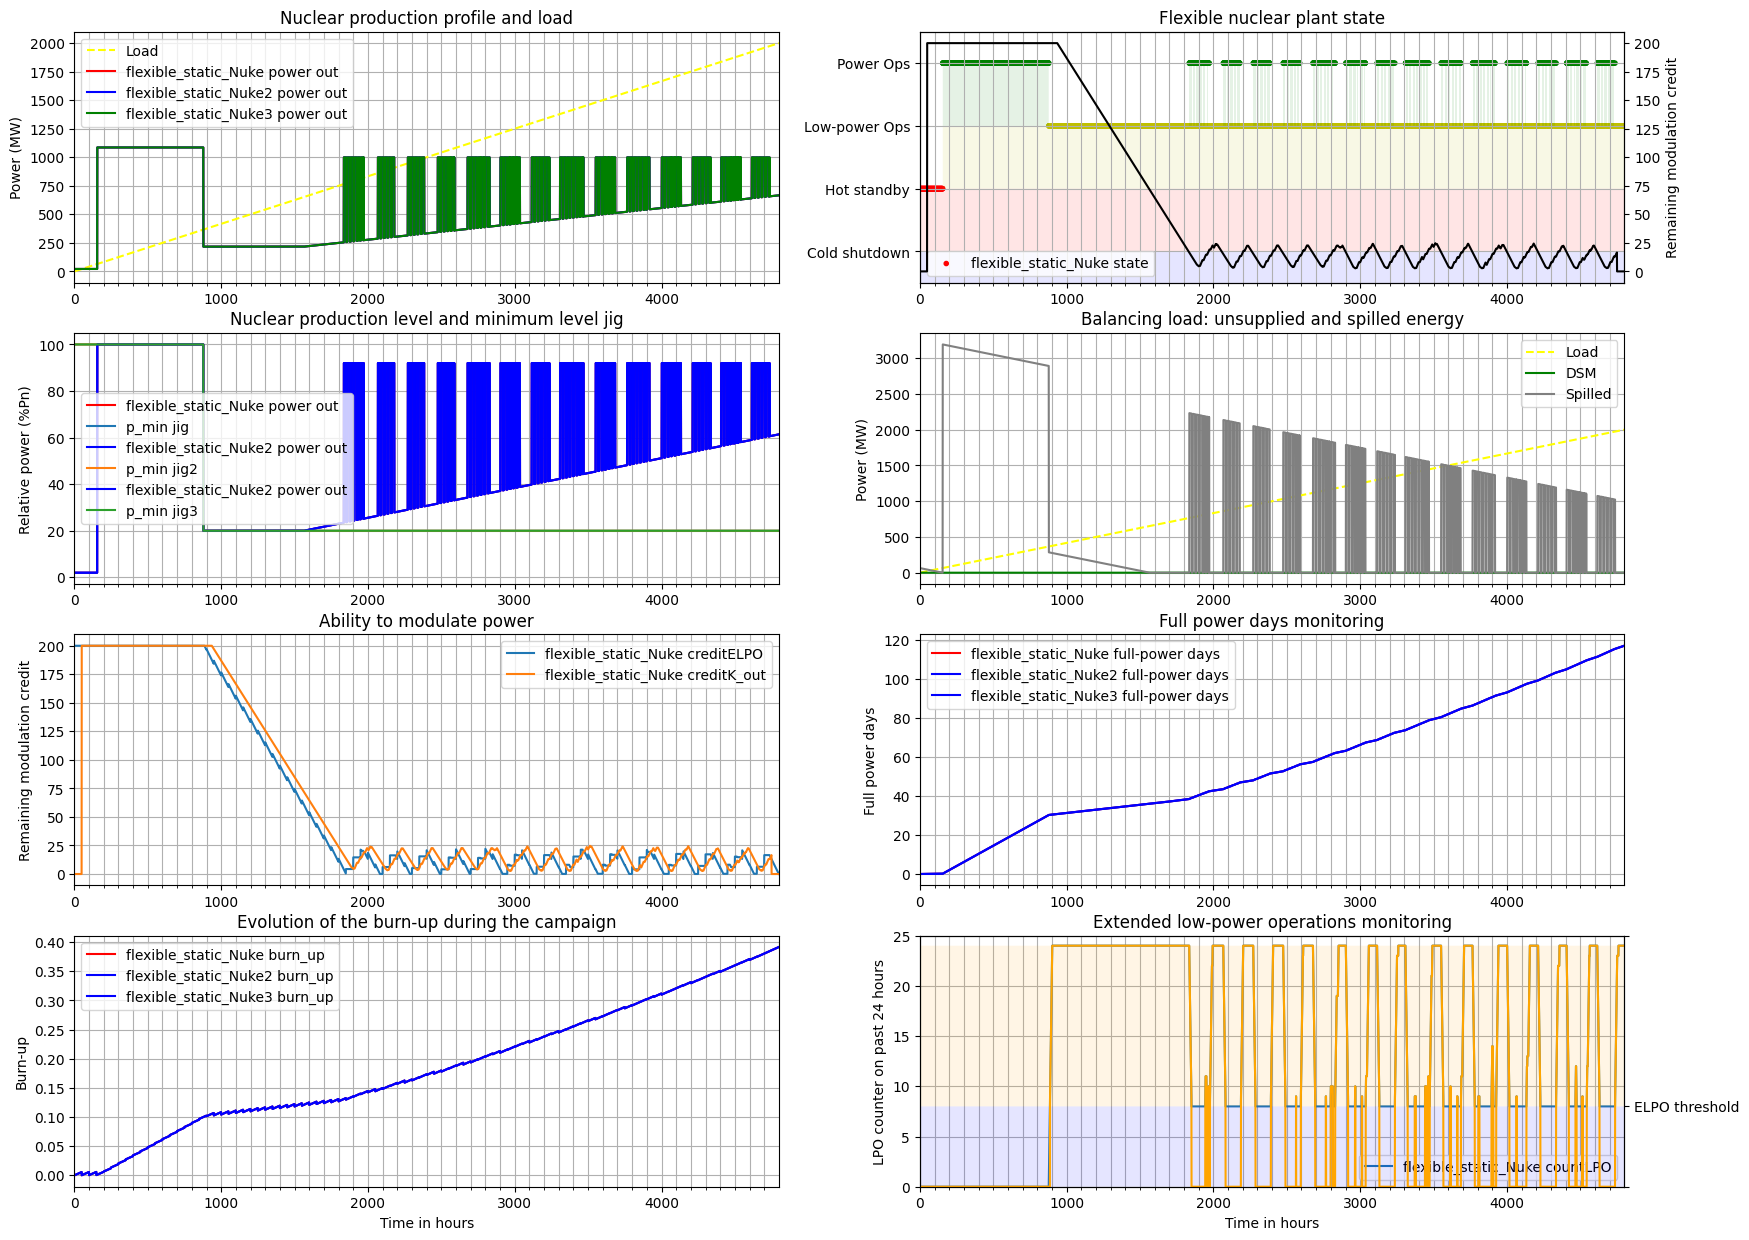

In [22]:
x_lb = 0
x_ub = global_step_count
grid_x_ticks = np.arange(x_lb, x_ub, 100)

# x_lb = 1600
# x_ub = 2000
# grid_x_ticks = np.arange(x_lb, x_ub, 1)

if True:
    fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2, figsize=(20,15))
    # grid_x_ticks = np.arange(x_lb, x_ub, 1)


    for ax in [ax11, ax12, ax21, ax22, ax31, ax32, ax41, ax42]:
        ax.set_xlim(x_lb, x_ub)
        ax.set_xticks(grid_x_ticks , minor=True)
        ax.grid(which="both")
    # end for x axis bounding
    
    ################################################################################################
    if True:
        ax11.title.set_text("Nuclear production profile and load")
        
        ax11.set_ylabel("Power (MW)")

        ax11.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

        if global_bool_Nuke_indiv:
            ax11.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
            ax11.plot(results["flexible_static_Nuke2"]["electricity"], label = "flexible_static_Nuke2 power out", color="b")
            ax11.plot(results["flexible_static_Nuke3"]["electricity"], label = "flexible_static_Nuke3 power out", color="green")

        # end if

        if global_bool_Nuke_cluster:
            ax11.plot(results["cluster_Nuke"]["power_out"], label = "Cluster_Nuke power out", color="orange")
        # end if

        if global_bool_CCGT_cluster:
            ax11.plot(results["cluster_CCGT"]["power_out"], label = "Cluster_CCGT power out", color="b")
        # end if

        # ax11.set_xlabel("Time in hours")
        ax11.legend()
    # end if True for graph (1,1)
    ################################################################################################
    if True:
        ax12.title.set_text("Flexible nuclear plant state")
        
        ax12.set_ylim(5, 45)
        
        labels = ["Cold shutdown", "Hot standby", "Low-power Ops", "Power Ops"]
        colors = ["b", "r", "y", "g"]
        ax12.set_yticks([10,20,30,40], labels)
        ax12.tick_params(axis="y")

        ax12bis = ax12.twinx()
        ax12bis.set_ylabel("Remaining modulation credit")
        ax12bis.tick_params(axis="y")

        if global_bool_Nuke_indiv:
            state = 10*results["flexible_static_Nuke"]["CS"] + 20*results["flexible_static_Nuke"]["HS"] + 30*results["flexible_static_Nuke"]["LPO"] + 40*results["flexible_static_Nuke"]["PO"]

            # Setting colors for better understanding of states
            statec = []
            for t in range(len(state)):
                statec.append(colors[int(state[t]//10)-1])

            time = range(global_step_count)
            ax12.scatter(x = time, y=state, c=statec, marker=".", label = "flexible_static_Nuke state")

            ax12bis.plot(results["flexible_static_Nuke"]["creditK_out"], color = "black", label = "flexible_static_Nuke crédit K")

            ax12.fill_between(time, 10, 0, where=(state>=10), facecolor="b", alpha=.1)
            ax12.fill_between(time, 20, 10, where=(state>=20), facecolor="r", alpha=.1)
            ax12.fill_between(time, 30, 20, where=(state>=30), facecolor="y", alpha=.1)
            ax12.fill_between(time, 40, 30, where=(state>=40), facecolor="g", alpha=.1)
        # end if

        ax12.legend()
    # end if True for graph (1,2)
    ################################################################################################
    if True:
        ax21.title.set_text("Nuclear production level and minimum level jig")

        ax21.set_ylabel("Relative power (%Pn)")

        if global_bool_Nuke_indiv:
            ax21.plot(results["flexible_static_Nuke"]["electricity"]/NPP_P_max*100, label = "flexible_static_Nuke power out", color="r")
            ax21.plot(ratio_p_min, label = "p_min jig")

            ax21.plot(results["flexible_static_Nuke2"]["electricity"]/NPP_P_max*100, label = "flexible_static_Nuke2 power out", color="b")
            ax21.plot(ratio_p_min2, label = "p_min jig2")

            ax21.plot(results["flexible_static_Nuke3"]["electricity"]/NPP_P_max*100, label = "flexible_static_Nuke2 power out", color="b")
            ax21.plot(ratio_p_min3, label = "p_min jig3")
        # end if

        ax21.legend()
    # end if True for graph (2,1)
    ################################################################################################
    if True:
        ax22.title.set_text("Balancing load: unsupplied and spilled energy")

        ax22.set_ylabel("Power (MW)")
        
        ax22.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

        if global_bool_virtual_balancing:
            ax22.plot(results["Demand_side_Management"]["power_out"], label = "DSM", color="g")
            ax22.plot(results["spilled_energy"]["power_in"], label = "Spilled", color="grey")
        # end if

        ax22.legend()
    # end if True for graph (2,2)
    ################################################################################################
    if True:
        ax31.title.set_text("Ability to modulate power")

        ax31.set_ylabel("Remaining modulation credit")

        if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
            ax31.plot(results["flexible_static_Nuke"]["creditELPO"], label = "flexible_static_Nuke creditELPO")
            ax31.plot(results["flexible_static_Nuke"]["creditK_out"], label = "flexible_static_Nuke creditK_out")
        # end if

        ax31.legend()
    # end if True for graph (3, 1)
    ################################################################################################
    if True:
        ax32.title.set_text("Full power days monitoring")

        ax32.set_ylabel("Full power days")
    
        if global_bool_Nuke_indiv and global_NPP_bool_fpd:
            ax32.plot(results["flexible_static_Nuke"]["fpd"], label = "flexible_static_Nuke full-power days", color="r")
            ax32.plot(results["flexible_static_Nuke2"]["fpd"], label = "flexible_static_Nuke2 full-power days", color="b")
            ax32.plot(results["flexible_static_Nuke3"]["fpd"], label = "flexible_static_Nuke3 full-power days", color="b")
        # end if

        ax32.legend()
    # end if True for graph (3, 2)
    ################################################################################################
    if True:
        ax41.title.set_text("Evolution of the burn-up during the campaign")

        ax41.set_xlabel("Time in hours")
        ax41.set_ylabel("Burn-up")

        if global_bool_Nuke_indiv and global_NPP_bool_fpd:
            ax41.plot(results["flexible_static_Nuke"]["burn_up"], label = "flexible_static_Nuke burn_up", color="r")
            ax41.plot(results["flexible_static_Nuke2"]["burn_up"], label = "flexible_static_Nuke2 burn_up", color="b")
            ax41.plot(results["flexible_static_Nuke3"]["burn_up"], label = "flexible_static_Nuke3 burn_up", color="b")
        # end if

        ax41.legend()
    # end if True for graph (4, 1)
    ################################################################################################
    if True:
        ax42.title.set_text("Extended low-power operations monitoring")

        ax42.set_ylim(0, 25)

        ax42.set_xlabel("Time in hours")
        ax42.set_ylabel("LPO counter on past 24 hours")

        labels = ["", "ELPO threshold", ""]

        ax42bis = ax42.twinx()
        ax42bis.set_ylim(0, 24)
        ax42bis.set_yticks([0,8,25], labels)
        ax42bis.tick_params(axis="y")

        if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
            count_LPO = results["flexible_static_Nuke"]["countLPO"]
            trimmed_LPO_during_ELPO = results["flexible_static_Nuke"]["countLPO"] * results["flexible_static_Nuke"]["is_step_ELPO"]

            ax42.plot(count_LPO, label = "flexible_static_Nuke countLPO")
            ax42bis.plot(trimmed_LPO_during_ELPO, label = "flexible_static_Nuke is_step_ELPO", color="orange")
        
            ax42bis.fill_between(time, 8, 0, facecolor="blue", alpha=.1)
            ax42bis.fill_between(time, 24, 8, facecolor="orange", alpha=.1)
        # end if
        
        ax42.legend()
    # end if True for graph (4, 2)
    ################################################################################################
    plt.savefig(fname="Results.png") 
    plt.show()
# end if True to be able to collapse the displaying code

## Questions et sujets en cours

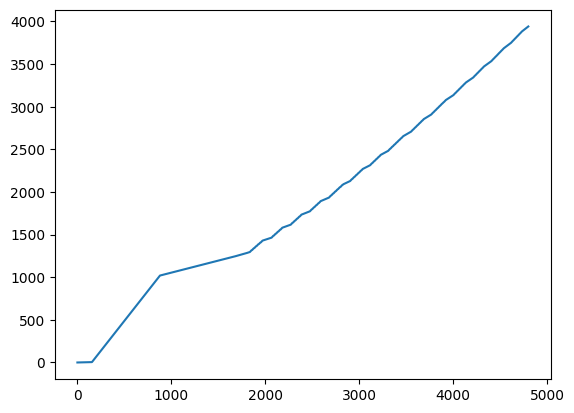

In [23]:
plt.plot((results["flexible_static_Nuke"]["fpd"] * NPP_P_max / NPP_efficiency) / NPP_fuel_weight)